In [1]:
import sys
#sys.path.append('/home/ardelalegre/SoundMapping/Analysis/Util')
sys.path.append('./Util')
#sys.path.append('/home/ardelalegre/SoundMapping/Database')
#sys.path.append('/home/ardelalegre/gerstoft/old')
#from DatabaseAPI import DatabaseAPI
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from Mapping import *
#from MappingPG import *
#from PIL import Image
#from get_time_interval_data import *
from PCA import *
#from Plot import *
#from get_clean_data import *
import pickle
import itertools
import random
%load_ext autoreload
%autoreload 2

In [2]:
# edit to print array 4 instead of array 5
def plot_doa_time_series(time_interval_matrix_data, arrays_to_disp):
    PLOT_LABELS = ['(a) ', '(b) ', '(c) ', '(d) ', '(e) ']
    data = time_interval_matrix_data
    length = data.shape[0]
    num_array = len(arrays_to_disp)
    fig = plt.figure(figsize = [16,15])
    for i in range(0,num_array):
        ax = fig.add_subplot(num_array,1,i+1)
        array_label = 'array {}'.format(arrays_to_disp[i] if arrays_to_disp[i]!=5 else 4)
        ax.plot(data[:,arrays_to_disp[i]*3+1], label='X')
        ax.plot(data[:,arrays_to_disp[i]*3+2], label='Y')
        ax.plot(data[:,arrays_to_disp[i]*3+3], label='Z') 
        ax.tick_params(axis='x', labelsize=21, width = 2, length = 8)
        ax.tick_params(axis='y', labelsize=21)
        ax.set_xlim(0,length)
        ax.set_ylim(-1,1)
        ax.axvline(2, color = 'r')
        ax.axvline(300, color = 'r')
        ax.axvline(450, color = 'r')
        ax.axvline(680, color = 'r')
        # keeping ticks while removing every other ticklabel
        list_xtick_labels = ax.xaxis.get_ticklabels()
        ax.axhline(0, color = 'k',linewidth=1)
        for k in range(len(list_xtick_labels)):
            if(k%2!=0):
                list_xtick_labels[k].set_visible(False)
        if i==0:
            ax.axvline(2, color = 'r')
            ax.text(4,1.05,'CP1',rotation=0,fontsize=18)
            ax.axvline(300, color = 'r')
            ax.text(302,1.05,'CP2',rotation=0,fontsize=18)
            ax.axvline(450, color = 'r')
            ax.text(453,1.05,'CP3',rotation=0,fontsize=18)
            ax.axvline(680, color = 'r')
            ax.text(682,1.05,'CP4',rotation=0,fontsize=18)   
            ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize=15, loc='upper right', borderpad=0.25, framealpha = 0.5)
        
        # removing tick labels for all ax except last
        if i!=num_array-1:
            ax.get_xaxis().set_ticklabels([])

    ax.set_xlabel("Time (samples)",fontsize=25)
    ax.set_ylabel("DOA amplitude",fontsize=25)
    plt.show()
    return fig

### Importing Data

In [3]:
# cp_list, active_L_table_slide_DOA, active_L_table_slide_matrix, active_long_table_slide_DOA, active_long_table_slide_matrix = get_V5_data()
# V5 = {
#     "cp_list": cp_list,
#     "active_L_table_slide_DOA": active_L_table_slide_DOA,
#     "active_L_table_slide_matrix": active_L_table_slide_matrix,
#     "active_long_table_slide_DOA": active_long_table_slide_DOA,
#     "active_long_table_slide_matrix": active_long_table_slide_matrix
# }

In [4]:
V5 = pickle.load(open('V5.p','rb'))
cp_list = V5["cp_list"]
active_L_table_slide_DOA = V5["active_L_table_slide_DOA"]
active_L_table_slide_matrix = V5["active_L_table_slide_matrix"]
active_long_table_slide_DOA = V5["active_long_table_slide_DOA"]
active_long_table_slide_matrix = V5["active_long_table_slide_matrix"]

In [5]:
TABLE_CP_IND = [0,1,2,3,4,5]
CHAIR_CP_IND = [6,7,8,9,10]

### Sliding Time Series

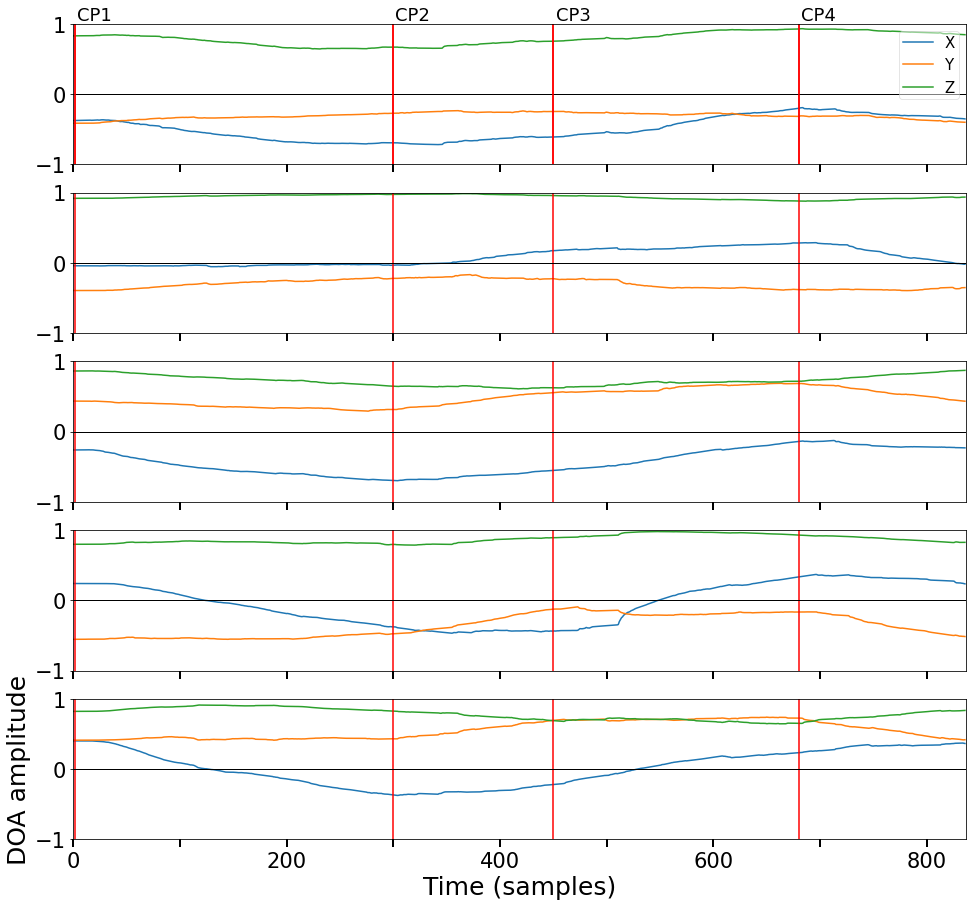

In [6]:
# cp 1: 0
# cp 2: 300
# cp 3: 450
# cp 4: 680
figDOA=plot_doa_time_series(active_L_table_slide_matrix, [0,1,2,3,5])
#figDOA.savefig('DOAslideTable.pdf', bbox_inches='tight', pad_inches=0)

### Singular Values & Vectors

In [7]:
EIGEN_VALUES_TABLE, EIGEN_VECTORS_TABLE = get_eigen_vectors(np.vstack([cp_list[i] for i in TABLE_CP_IND]))
EIGEN_VALUES_CHAIR, EIGEN_VECTORS_CHAIR = get_eigen_vectors(np.vstack([cp_list[i] for i in CHAIR_CP_IND]))
EIGEN_VALUES_ALL,   EIGEN_VECTORS_ALL   = get_eigen_vectors(np.vstack(cp_list))
SIN_VALUES_TABLE = eigen2singular(EIGEN_VALUES_TABLE)
SIN_VALUES_CHAIR = eigen2singular(EIGEN_VALUES_CHAIR)
SIN_VALUES_ALL   = eigen2singular(EIGEN_VALUES_ALL)
EIG_DATA_NAME = ['Table','Chair','All']
SIN_VAL_LIST = [SIN_VALUES_TABLE, SIN_VALUES_CHAIR, SIN_VALUES_ALL]
EIG_VAL_LIST = [EIGEN_VALUES_TABLE, EIGEN_VALUES_CHAIR, EIGEN_VALUES_ALL]
EIG_VEC_LIST = [EIGEN_VECTORS_TABLE, EIGEN_VECTORS_CHAIR, EIGEN_VECTORS_ALL]

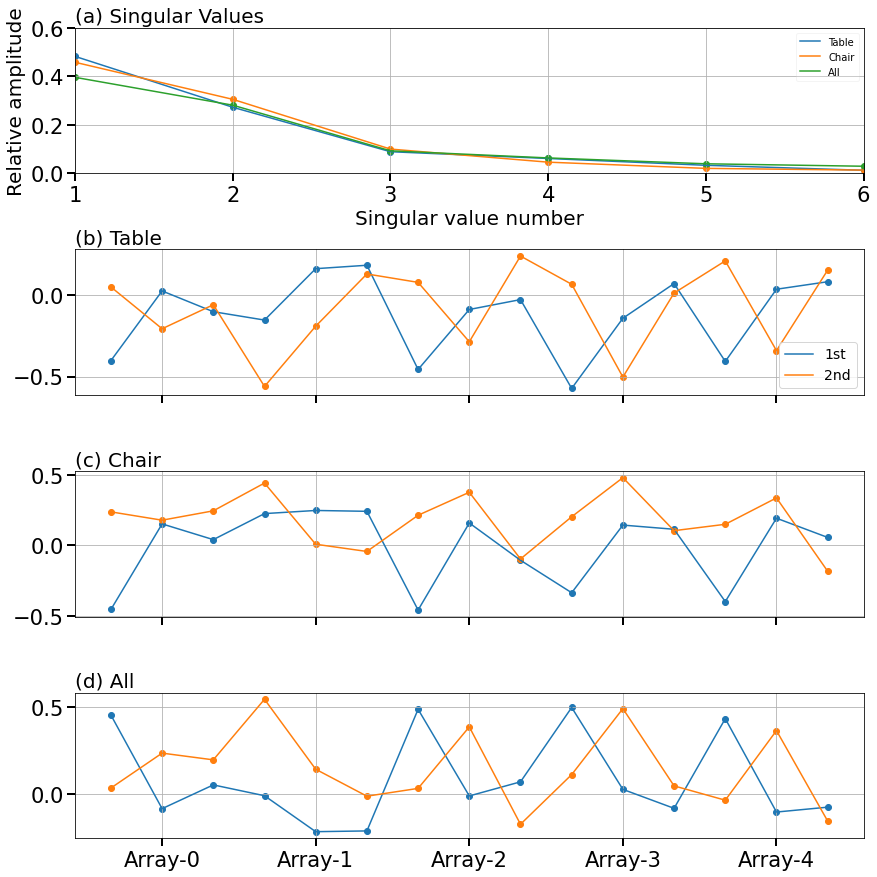

In [8]:
N_SETS = len(EIG_DATA_NAME)
N_VALUES = 15
N_EIGEN = 2 # top 2 eigen vectors
COLOR_LIST = ['r','b','g','y','c']
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])
PLOT_LABELS = ['(a) ', '(b) ', '(c) ', '(d) ']

fig, axes = plt.subplots(N_SETS+1, 1, sharex=False, sharey=False, figsize=[12,12])
# fig.suptitle('Singular Vectors Calculated with Different Sets',fontsize=15)
for ii in range(N_SETS+1):    
    # adds subplot to figure i.e. adds another row
    ax = axes[ii]  
    ax.tick_params(axis='x', labelsize=21, width = 2, length = 8)
    ax.tick_params(axis='y', labelsize=21, width = 2, length = 8)
    if ii==0:
        for jj in range(N_SETS):
            ax.plot(range(1,N_VALUES+1),SIN_VAL_LIST[jj],label=EIG_DATA_NAME[jj])
            ax.scatter(range(1,N_VALUES+1),SIN_VAL_LIST[jj])
            ax.set_xticks(np.arange(1,N_VALUES+1,step=1))
            ax.set_ylim(0,0.6)
            ax.set_xlim(1,6)
            ax.grid()
            ax.legend(framealpha = 0.2)
        ax.set_xlabel("Singular value number",fontsize=20)
        ax.set_ylabel("Relative amplitude",fontsize=20)
        ax.set_title(PLOT_LABELS[ii] + 'Singular Values',fontsize=20, loc = 'left')
    else:    
        ordinal_list = [ordinal(n) for n in range(1,3+1)] # num_eigen
        for jj in range(N_EIGEN): # num_eigen
            ax.plot(range(1,N_VALUES+1),EIG_VEC_LIST[ii-1][:,jj],label=ordinal_list[jj])
            ax.scatter(range(1,N_VALUES+1),EIG_VEC_LIST[ii-1][:,jj])
        ax.set_title(PLOT_LABELS[ii] + EIG_DATA_NAME[ii-1], fontsize=20, loc = 'left') 
        ax.grid()
        ax.set_xticks(range(2,16,3))
        if ii==3:
            ax.set_xticklabels(["Array-0", "Array-1", "Array-2","Array-3","Array-4"])
        if ii==1:
#            ax.legend(bbox_to_anchor=(1.0, 1.6), fontsize=14)
            ax.legend(markerscale=0,fontsize=14,loc='lower right')
    
        # Hiding tick labels in b and c
        if ii == 1 or ii == 2:
            ax.get_xaxis().set_ticklabels([])
            
        # making ticks stronger


fig.tight_layout(pad=0.05)
plt.show()
#fig.savefig('SingularVectors.pdf', bbox_inches='tight', pad_inches=0)

### Calibration Points Mapping

In [9]:
PWD = '/home/ardelalegre/SoundMapping/Analysis/notebooks/data/'
DOA_LIST = cp_list
ROOM_COORDINATES = ROOM_COORDINATES
TABLE_CP_IND = [0,1,2,3,4,5]
CHAIR_CP_IND = [6,7,8,9,10]
ALL_CP_IND   = [0,1,2,3,4,5,6,7,8,9,10]
DATA_IND = [TABLE_CP_IND,CHAIR_CP_IND,ALL_CP_IND]

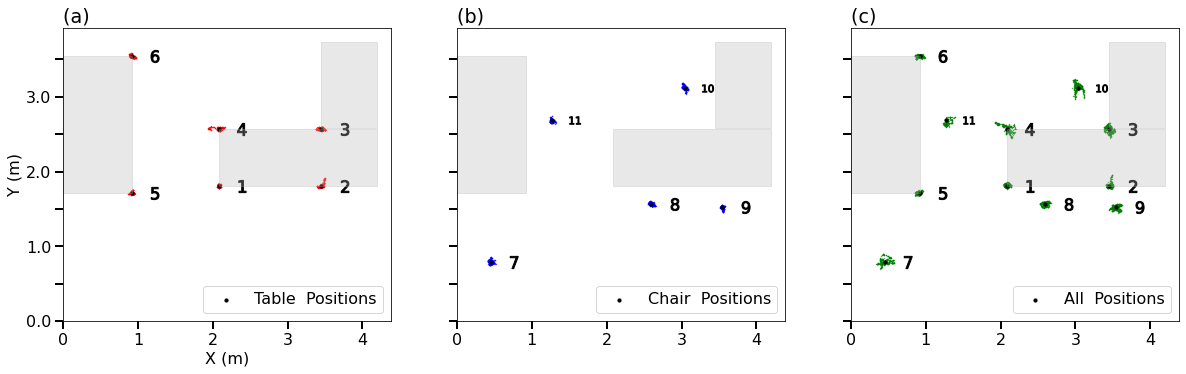

array([[2.08 , 1.81 , 0.78 ],
       [3.45 , 1.81 , 0.78 ],
       [3.45 , 2.57 , 0.78 ],
       [2.08 , 2.57 , 0.78 ],
       [0.92 , 1.71 , 0.78 ],
       [0.92 , 3.54 , 0.78 ],
       [0.45 , 0.791, 0.5  ],
       [2.598, 1.567, 0.5  ],
       [3.544, 1.523, 0.5  ],
       [3.04 , 3.12 , 0.5  ],
       [1.266, 2.685, 0.5  ]])

In [10]:
fig = plt.figure(figsize = [20,8])
plt.rcParams['font.size'] = '16'
DATA_NAME = ['Table','Chair','All']
COLOR_LIST = ['r','b','g','y','c']
MARKER_LIST = ["$1$","$2$","$3$","$4$","$5$","$6$","$7$","$8$","$9$","$10$","$11$"]
B_MATRIX_LIST = []
PLOT_LABELS = ['(a) ', '(b) ', '(c) ']

for ii in range(len(DATA_IND)):
    DOA_points = [DOA_LIST[IND] for IND in DATA_IND[ii]]
    room_coordinates = ROOM_COORDINATES[DATA_IND[ii],:]
    B,R_mean,D_mean,D = generate_linear_transform_matrix(DOA_points, room_coordinates, 2) 
    # find displacement of mean in room space
    R_0 = R_mean-B @ D_mean
    # affine transform all DOA points
    r = R_0 + B @ D
    B_MATRIX_LIST.append(B)
        
    # plotting background tables
    ax1 = fig.add_subplot(1,len(DATA_NAME),ii+1)
    rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
    rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
    rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')
    ax1.add_patch(rect_side_table)
    ax1.add_patch(rect_main_table_1)
    ax1.add_patch(rect_main_table_2)
#     lc = mc.LineCollection(lines, colors='k', linewidths=2)
#     ax1.add_collection(lc)
    
    ax1.scatter(r[0,:], r[1,:],  c =COLOR_LIST[ii], s = 0.1)
    if ii == 0:
        ax1.set_xlabel("X (m)")
        ax1.set_ylabel("Y (m)")
    ax1.set_aspect('equal')
    ax1.set(xlim=(0,4.385), ylim=(0,3.918))
    ax1.scatter(room_coordinates[:,0],
                room_coordinates[:,1], 
                c = 'k', s = 10, label = '{}  Positions'.format(DATA_NAME[ii]))
    ax1.set_title(PLOT_LABELS[ii], loc = 'left')
    ax1.tick_params(axis='y', width=2, length=8)
    ax1.tick_params(axis='x', width=2, length=8)
    
    # keeping ticks while removing every other ticklabel
    list_xtick_labels = ax1.yaxis.get_ticklabels()
    for k in range(len(list_xtick_labels)):
        if(k%2!=0):
            list_xtick_labels[k].set_visible(False)
    
    ax1.legend(loc='lower right');
    for jj in range(room_coordinates.shape[0]):
        ax1.scatter(room_coordinates[jj,0]+0.3, room_coordinates[jj,1], 
                    marker=[MARKER_LIST[IND] for IND in DATA_IND[ii]][jj], 
                    s=150, c='k')
        
    # removing tick labels for all ax1 except first
    if ii!=0:
        ax1.get_yaxis().set_ticklabels([])
#     ax1.tick_params(axis='x', labelsize=21, width = 2, length = 8)
#     ax1.tick_params(axis='y', labelsize=21)


        
plt.show()

#print('R_0',R_0,'R_mean', R_mean, 'D_mean',D_mean)
room_coordinates
#fig.savefig('Mappingpoints.pdf', bbox_inches='tight', pad_inches=0)

### B Matrix Color Bars

In [11]:
# going through the B values to find the largest and the smallest value across the matrices
# stack the matrices and make a new numpy array out of them. Then get min and max from the array.
ALL_B_MATRIX = np.vstack(B_MATRIX_LIST)
B_MIN = np.amin(ALL_B_MATRIX)
B_MAX = np.amax(ALL_B_MATRIX)

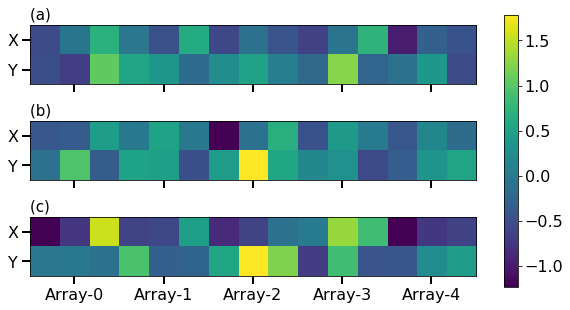

In [12]:
# plotting
fig, axes = plt.subplots(nrows=len(B_MATRIX_LIST), ncols=1, figsize = [10,5])
norm = matplotlib.colors.Normalize(vmin=B_MIN+0.5, vmax=B_MAX-0.5)
c_axes = matplotlib.colorbar.make_axes(axes)
PLOT_LABLES = ['(a) ', '(b) ', '(c) ']

                         
for i in range(len(B_MATRIX_LIST)):
    axes[i].imshow(B_MATRIX_LIST[i], norm = norm)
    axes[i].set_yticks([0, 1])
    axes[i].set_yticklabels(["X", "Y"])
    axes[i].set_xticks(range(1,15,3))
    axes[i].set_xticklabels([])
    axes[i].set_title(PLOT_LABLES[i], fontsize=15, loc = 'left')
    # only add labels to the last image
    if i==len(B_MATRIX_LIST)-1:
        axes[i].set_xticks(range(1,15,3))
        axes[i].set_xticklabels(["Array-0", "Array-1", "Array-2","Array-3","Array-4"])
    # making ticks of both axes stronger
    axes[i].tick_params(axis='x', width = 2, length = 8)
    axes[i].tick_params(axis='y', width = 2, length = 8)

cb1 = matplotlib.colorbar.ColorbarBase(c_axes[0], norm=norm);
#fig.savefig('Bmatrix.pdf', bbox_inches='tight', pad_inches=0)

### L Table Slide Mapping

In [13]:
#PWD = '/home/ardelalegre/SoundMapping/Analysis/notebooks/data/'
DOA_LIST = cp_list
ROOM_COORDINATES = ROOM_COORDINATES
TABLE_CP_IND = [0,1,2,3,4,5]
CHAIR_CP_IND = [6,7,8,9,10]
ALL_CP_IND   = [0,1,2,3,4,5,6,7,8,9,10]
L_TABLE_CP_IND = [0,1,2,3]
LONG_TABLE_CP_IND = [4,5]
DATA_IND = [TABLE_CP_IND,CHAIR_CP_IND,ALL_CP_IND]

In [14]:
# use cp1 to calculate displacement for L table slide
R_1 = ROOM_COORDINATES[0,:2].T.reshape(-1,1)
D_1 = np.median(DOA_LIST[0], axis=0).reshape(-1,1)

# use cp6 to calculate displacement for long table slide
R_6 = ROOM_COORDINATES[5,:2].T.reshape(-1,1)
D_6 = np.median(DOA_LIST[5], axis=0).reshape(-1,1)

R_LIST = [R_1, R_6]
D_LIST = [D_1, D_6]

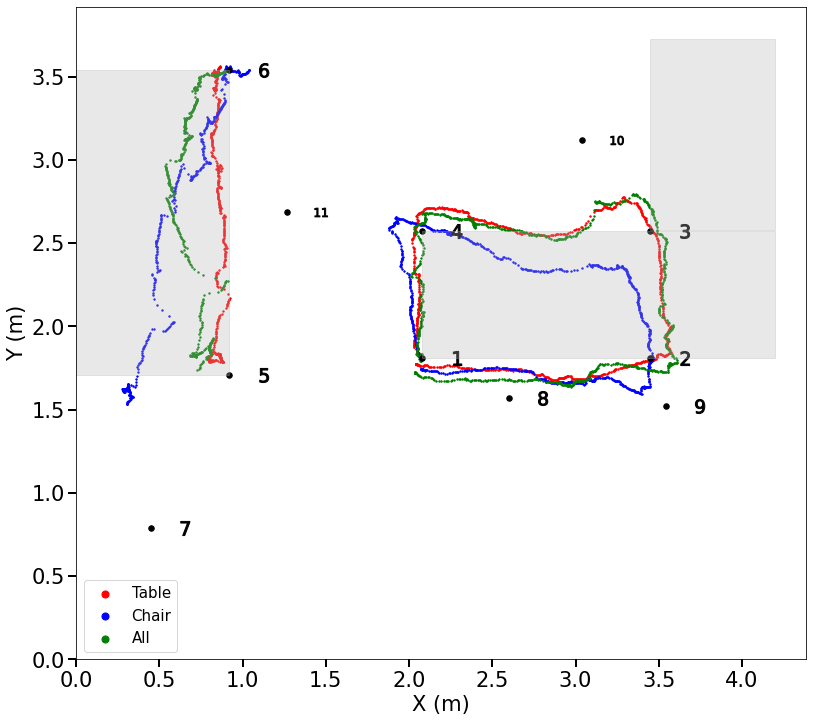

In [15]:
EVENT_DOA = [active_L_table_slide_DOA, active_long_table_slide_DOA]
EVENT_LABEL = ['L Table Slide', 'Long Table slide']
B_MATRIX_NAME = ['Table','Chair','All']
COLOR_LIST = ['r','b','g']
MARKER_LIST = ["$1$","$2$","$3$","$4$","$5$","$6$","$7$","$8$","$9$","$10$","$11$"]

fig = plt.figure(figsize = [16,12])
plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(1,1,1)
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

for ii in range(len(EVENT_DOA)):
    for jj in range(len(DATA_IND)):
        DOA_points = [DOA_LIST[IND] for IND in DATA_IND[jj]]
        room_coordinates = ROOM_COORDINATES[DATA_IND[jj],:]
        B,R_mean,D_mean,D = generate_linear_transform_matrix(DOA_points, room_coordinates, 2) 
        R_0 = R_LIST[ii]-B @ D_LIST[ii]
        r = R_0 +B @ EVENT_DOA[ii].T
        # only plot with label once
        if ii==0:
            ax.scatter(r[0,:], r[1,:], c=COLOR_LIST[jj], s=2) 
        else:
            ax.scatter(r[0,:], r[1,:], c=COLOR_LIST[jj], s=2, label=B_MATRIX_NAME[jj])    
ax.add_patch(rect_side_table)
ax.add_patch(rect_main_table_1)
ax.add_patch(rect_main_table_2)
ax.set_xlabel("X (m)", fontsize = 21)
ax.set_ylabel("Y (m)", fontsize = 21)
ax.set_aspect('equal')
ax.set(xlim=(0,4.385), ylim=(0,3.918))
ax.scatter(ROOM_COORDINATES[:,0],ROOM_COORDINATES[:,1], c='k', s=30)
ax.tick_params(axis='y', labelsize = 21, width = 2, length = 8)
ax.tick_params(axis='x',labelsize = 21, width = 2, length = 8)

for kk in range(ROOM_COORDINATES.shape[0]):
    ax.scatter(ROOM_COORDINATES[kk,0]+0.2, ROOM_COORDINATES[kk,1], marker=MARKER_LIST[kk], s=200, c='k')
ax.legend(markerscale=5,fontsize=15)
plt.show()
# fig.savefig('Mappingtables.pdf', bbox_inches='tight', pad_inches=0)

### PCA Using Three Different CP Sets

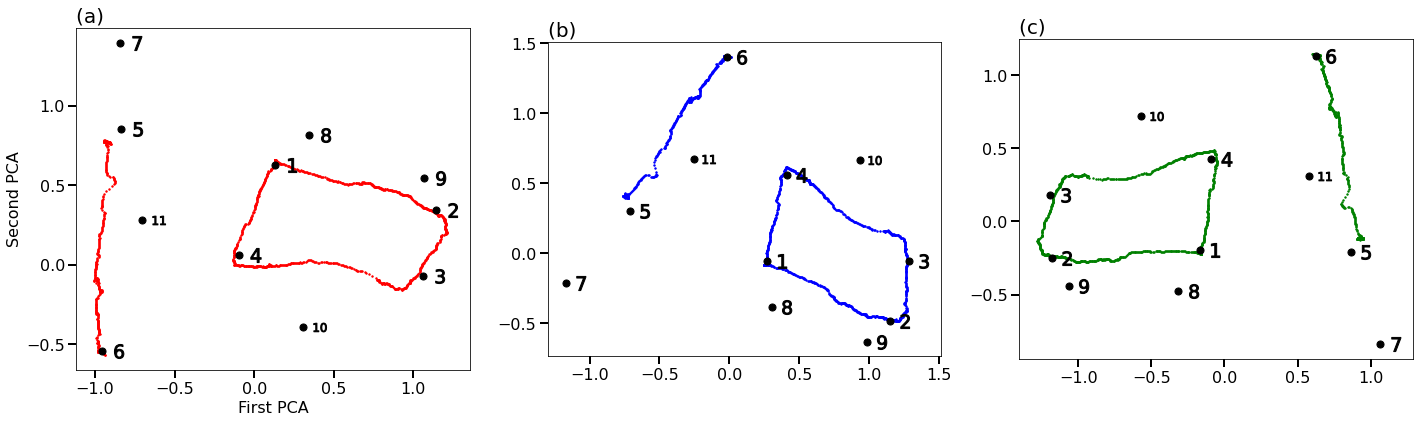

In [16]:
EIG_DATA_NAME = ['Table','Chair','All']
EIG_VAL_LIST = [EIGEN_VALUES_TABLE, EIGEN_VALUES_CHAIR, EIGEN_VALUES_ALL]
EIG_VEC_LIST = [EIGEN_VECTORS_TABLE, EIGEN_VECTORS_CHAIR, EIGEN_VECTORS_ALL]
EVENT_DOA = [active_L_table_slide_DOA, active_long_table_slide_DOA]
DOA_LIST = cp_list
ROOM_COORDINATES = ROOM_COORDINATES

fig = plt.figure(figsize = [20,16])
COLOR_LIST = ['r','b','g','y','c']
MARKER_LIST = ["$1$","$2$","$3$","$4$","$5$","$6$","$7$","$8$","$9$","$10$","$11$"]
PLOT_LABLES = ['(a) ', '(b) ', '(c) ']

for ii in range(len(EIG_DATA_NAME)):
    # plotting
    ax = fig.add_subplot(1,3,ii+1)
    
    for jj in range(len(EVENT_DOA)):
        event_projections = project_to_eigen_vectors(EVENT_DOA[jj], 2, 
                                               EIG_VAL_LIST[ii], 
                                               EIG_VEC_LIST[ii])

        ax.scatter(event_projections[:,0], event_projections[:,1], c=COLOR_LIST[ii], s=2)
        
        
    cp = np.hstack([np.median(DOA_LIST[IND], axis=0).reshape(-1,1) for IND in range(len(DOA_LIST))])
    cp_projections = project_to_eigen_vectors(cp.T, 2,
                                              EIG_VAL_LIST[ii], 
                                              EIG_VEC_LIST[ii])

    ax.scatter(cp_projections[:,0], cp_projections[:,1], c='k', s=50)
    ax.set_title(PLOT_LABLES[ii], fontsize=20, loc='left')
    
    for kk in range(cp_projections.shape[0]):
        ax.scatter(cp_projections[kk,0]+0.1, cp_projections[kk,1], marker=MARKER_LIST[kk], s=200, c='k')
        
    ax.set_aspect('equal')
    if ii == 0:
        ax.set_xlabel("First PCA") 
        ax.set_ylabel("Second PCA")
    ax.tick_params(axis='y', width=2, length=8)
    ax.tick_params(axis='x', width=2, length=8)
    plt.locator_params(axis='y', nbins=6)
    plt.tight_layout()
 #    fig.savefig('PCAMap.pdf', bbox_inches='tight', pad_inches=0)

### PCA With Array Dropping

In [17]:
ARRAY_IND_LIST = np.array([0,1,2,3,4]) # since array 5 is at index 4
# N choose R
TOTAL_ARRAY_NUM = 5 # N
CHOOSE_ARRAY_NUM = 1  # R
COMBO_LIST = list(itertools.combinations(range(TOTAL_ARRAY_NUM), CHOOSE_ARRAY_NUM)) # combinations of R elements from N
EIGEN_VALUES_L_TABLE, EIGEN_VECTORS_L_TABLE = get_eigen_vectors(np.vstack([cp_list[i] for i in range(4)]))

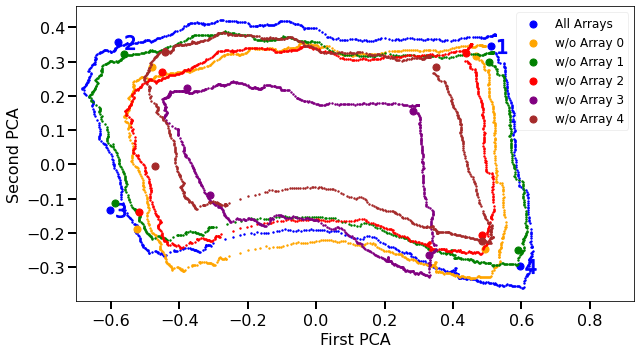

In [18]:
# Plotting
LABEL_LIST = ['w/o Array 0', 'w/o Array 1', 'w/o Array 2', 'w/o Array 3', 'w/o Array 4']
PLOT_LABLES = ['(a) ', '(b) ']
fig = plt.figure(figsize = [10,12])
plt.rcParams['font.size'] = '16'
COLOR_LIST = [ 'orange', 'g','r','purple','brown']

ax = fig.add_subplot(1,1,1)
# first plot PCA with all arrays
projection = project_to_eigen_vectors(active_L_table_slide_DOA, 2, EIGEN_VALUES_L_TABLE, EIGEN_VECTORS_L_TABLE)
# ax.scatter(projection[:,0], projection[:,1], s=2, label='All Arrays')
# i = 0
# for combo in COMBO_LIST:
#     which_arrays = ARRAY_IND_LIST[list(combo)]
#     inactive_ind = get_indices_from_combination(which_arrays)
#     # set first track to zero
#     tmp = active_L_table_slide_DOA.copy()[:300,:]
#     tmp[:300,inactive_ind] = 0
#     # project first track
#     projection = project_to_eigen_vectors(tmp, 2, EIGEN_VALUES_L_TABLE, EIGEN_VECTORS_L_TABLE)
#     ax.scatter(projection[:,0], projection[:,1], s=2, c=COLOR_LIST[i],label=LABEL_LIST[i])
#     i = i + 1
#     ax.set_aspect('equal')
#     ax.set_xlabel("First PCA")  
#     ax.set_ylabel("Second PCA")
# ax.legend(markerscale=5,fontsize=13,loc='upper right')
# ax.set_title(PLOT_LABLES[0], fontsize=15, loc='left')

# ax = fig.add_subplot(2,1,2)
# # first plot PCA with all arrays
projection = project_to_eigen_vectors(active_L_table_slide_DOA, 2, EIGEN_VALUES_L_TABLE, EIGEN_VECTORS_L_TABLE)
ax.scatter(projection[:,0], projection[:,1], s=2,  c='b', label='All Arrays')
cp = np.hstack([np.median(DOA_LIST[IND], axis=0).reshape(-1,1) for IND in range(4)]).T
cp_projections = project_to_eigen_vectors(cp, 2,
                                           EIGEN_VALUES_L_TABLE, 
                                           EIGEN_VECTORS_L_TABLE)
ax.scatter(cp_projections[:4,0], cp_projections[:4,1], c='b', s=50)
for kk in range(4):
    ax.scatter(cp_projections[kk,0]+0.03, cp_projections[kk,1], marker=MARKER_LIST[kk], s=200, c='b')
i = 0
for combo in COMBO_LIST:
    which_arrays = ARRAY_IND_LIST[list(combo)]
    inactive_ind = get_indices_from_combination(which_arrays)
    # set first track to zero
    tmp = active_L_table_slide_DOA.copy()
    tmp[:,inactive_ind] = 0
    # project first track
    projection = project_to_eigen_vectors(tmp, 2, EIGEN_VALUES_L_TABLE, EIGEN_VECTORS_L_TABLE)
    ax.scatter(projection[:,0], projection[:,1], s=2, c=COLOR_LIST[i], label=LABEL_LIST[i])
    # add calibration points
    cp = np.hstack([np.median(DOA_LIST[IND], axis=0).reshape(-1,1) for IND in range(len(DOA_LIST))]).T
    cp[:,inactive_ind] = 0
    cp_projections = project_to_eigen_vectors(cp, 2,
                                              EIGEN_VALUES_L_TABLE, 
                                              EIGEN_VECTORS_L_TABLE)
    ax.scatter(cp_projections[:4,0], cp_projections[:4,1], c=COLOR_LIST[i], s=50)

    i = i + 1
    ax.set_aspect('equal')
    ax.set_xlabel("First PCA")  
    ax.set_ylabel("Second PCA")
ax.tick_params(axis='x', width=2, length=8)
ax.tick_params(axis='y', width=2, length=8)
ax.set_aspect('equal')
ax.set(xlim=(-0.7,0.93)) #, ylim=(0,3.918))
ax.legend(markerscale=5,fontsize=12,loc='upper right', framealpha = 0.3)
#ax.set_title(PLOT_LABLES[1], fontsize=15, loc='left')

plt.show()
#fig.savefig('PCAMapMiss1array.pdf', bbox_inches='tight', pad_inches=0)

### B Matrix Mapping with Dropping Arrays

In [19]:
PWD = '/home/ardelalegre/SoundMapping/Analysis/notebooks/data/'
DOA_LIST = cp_list
ROOM_COORDINATES = ROOM_COORDINATES

# use cp 1 to calculate displacement for L table slide
R_1 = ROOM_COORDINATES[0,:2].T.reshape(-1,1)
D_1 = np.median(DOA_LIST[0], axis=0).reshape(-1,1)

# use cp 6 to calculate displacement for long table slide
R_6 = ROOM_COORDINATES[5,:2].T.reshape(-1,1)
D_6 = np.median(DOA_LIST[5], axis=0).reshape(-1,1)

R_LIST = [R_1, R_6]
D_LIST = [D_1, D_6]

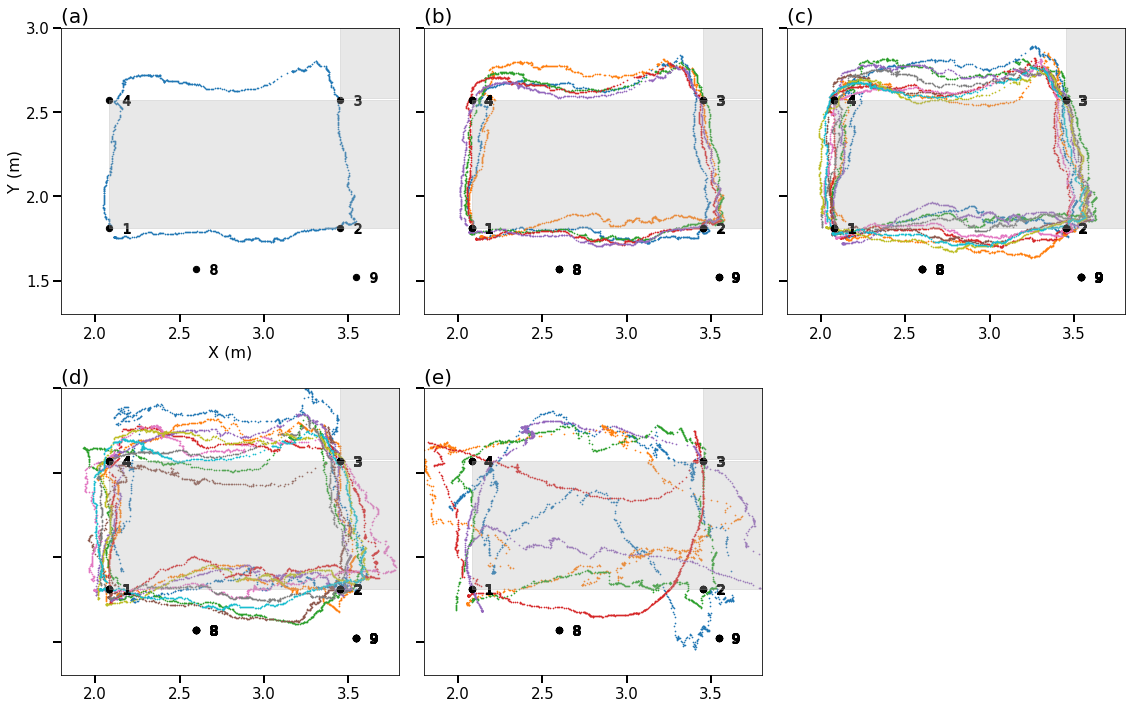

In [20]:
EVENT_DOA = active_L_table_slide_DOA
DOA_LIST = cp_list[:4]
ROOM_COORDINATES = ROOM_COORDINATES
L_TABLE_CP_IND = [0,1,2,3]
MARKER_LIST = ["$1$","$2$","$3$","$4$","$5$","$6$","$7$","$8$","$9$","$10$","$11$"]
PLOT_LABLES = ['(a) ', '(b) ', '(c) ', '(d) ','(e) ']
TOTAL_ARRAY_NUM = 5 # N

fig = plt.figure(figsize = [16,10])
LABEL_IND = 0
for CHOOSE_ARRAY_NUM in [5, 4, 3, 2, 1]: #[5, 4, 3, 2, 1]:
    rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
    rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
    rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

    ax = fig.add_subplot(2,3,6-CHOOSE_ARRAY_NUM)
    ax.add_patch(rect_main_table_1)
    ax.add_patch(rect_main_table_2)
    B_different_combinations = [] # will store all B matrices
    B_different_combinations_padded = []

    which_arrays = list(itertools.combinations(range(TOTAL_ARRAY_NUM), CHOOSE_ARRAY_NUM))

    for i in which_arrays:
        data_indices = get_indices_from_combination(i)
        DOA_points = [cp[:,data_indices] for cp in DOA_LIST]
        B,R_mean,D_mean,D = generate_linear_transform_matrix(DOA_points, ROOM_COORDINATES[:4,:], 2) 
    
        B_padded = pad_linear_transform_matrix(B, i)   
        B_different_combinations.append(B)
        B_different_combinations_padded.append(B_padded)
    
        # use B_padded
        R_0 = R_1 - B_padded @ D_1
        r = R_0 + B_padded @ EVENT_DOA.T

        ax.set(xlim=(1.8,3.8), ylim=(1.3,3))
        ax.scatter(r[0,:], r[1,:], s=0.5, label=i)
  #      ax.set_fontsize(16)
        ax.set_aspect('equal')
        ax.scatter(ROOM_COORDINATES[:,0], ROOM_COORDINATES[:,1], c ='k', s=40)
        for j in range(ROOM_COORDINATES.shape[0]):
            ax.scatter(ROOM_COORDINATES[j,0]+0.1, ROOM_COORDINATES[j,1], marker=MARKER_LIST[j] , s=100, c='k')
    ax.set_ylabel
    ax.set_title(PLOT_LABLES[LABEL_IND], fontsize=20, loc='left')

    LABEL_IND += 1
    plt.locator_params(axis='y', nbins=6)
    
    if CHOOSE_ARRAY_NUM == 5:
        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")
        
    # hiding tick labels for not 5
    if CHOOSE_ARRAY_NUM != 5:
        ax.get_yaxis().set_ticklabels([])
    # making ticks stronger
    ax.tick_params(axis='y',labelsize=15, width = 2, length = 8), ax.tick_params(axis='x',labelsize=15, width = 2, length = 8)

plt.tight_layout()

# fig.savefig('MappingtableMissingArrays.pdf', bbox_inches='tight', pad_inches=0)

### Random Array Dropping

In [21]:
DOA_LIST = cp_list
ROOM_COORDINATES = ROOM_COORDINATES

L_TABLE_CP_IND = [0,1,2,3]
EIGEN_VALUES_L_TABLE, EIGEN_VECTORS_L_TABLE = get_eigen_vectors(np.vstack([cp_list[i] for i in L_TABLE_CP_IND]))
B_FULL,_,_,_ = generate_linear_transform_matrix(DOA_LIST[:4], ROOM_COORDINATES[:,:4], 2) 

# use cp 1 to calculate displacement for L table slide
R_1 = ROOM_COORDINATES[0,:2].T.reshape(-1,1)
D_1 = np.median(DOA_LIST[0], axis=0).reshape(-1,1)

In [22]:
# Generate data

random.seed(10)
L = active_L_table_slide_DOA.shape[0]
# choose how many arrays are active
CHOOSE = 4
# choose dropping rate
OCCURANCE = 0.5
OCCURANCE_TIMEIND = random.sample(range(L),np.floor(L*OCCURANCE).astype('int'))
OCCURANCE_TIMEIND.sort()
mapped_r = []
mapped_p = []

# Create a random array indices for all observations, maybe 1 or more arrays are dropped

active_combo = []
inactive_combo = []
for jj in OCCURANCE_TIMEIND:
    active = random.sample([0,1,2,3,4],CHOOSE)
    inactive = list(set([0,1,2,3,4])-set(active))
    active_combo.append(active)
    inactive_combo.append(inactive)
    
# Calculation for B
tracker = 0
for ll in range(L):
    if ll in OCCURANCE_TIMEIND:
        combo = active_combo[tracker]
        tracker += 1
        data_indices = get_indices_from_combination(combo)
        DOA_points = [cp[:,data_indices] for cp in DOA_LIST[:4]]
        B,R_mean,D_mean,D = generate_linear_transform_matrix(DOA_points, ROOM_COORDINATES[:,:4], 2) 
        B_padded = pad_linear_transform_matrix(B, combo)   
        R_0 = R_1 - B_padded @ D_1
        r = R_0 + B_padded @ active_L_table_slide_DOA[ll,:].reshape(-1,1)
    else: 
        R_0 = R_1 - B_FULL @ D_1
        r = R_0 + B_FULL @ active_L_table_slide_DOA[ll,:].reshape(-1,1)
    mapped_r.append(r)
    
# Calculation for PCA 
tracker = 0
for ll in range(L):
    if ll in OCCURANCE_TIMEIND:
        combo = inactive_combo[tracker]
        tracker += 1
        data_indices = get_indices_from_combination(combo)
        tmp = active_L_table_slide_DOA[ll,:].copy()
        tmp[data_indices] = 0
    else: 
        tmp = active_L_table_slide_DOA[ll,:].copy()
    p = project_to_eigen_vectors(tmp, 2, EIGEN_VALUES_L_TABLE, EIGEN_VECTORS_L_TABLE)    
    mapped_p.append(p)

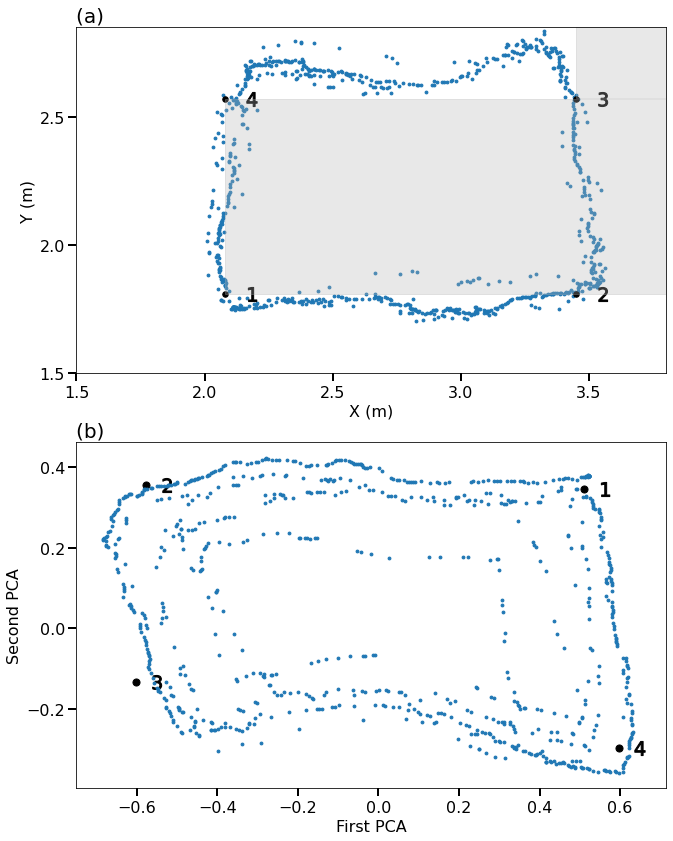

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = [12,14])
plt.rcParams['font.size'] = '18'
PLOT_LABLES = ['(a) ', '(b) ', '(c) ']

MARKER_LIST = ["$1$","$2$","$3$","$4$","$5$","$6$","$7$","$8$","$9$","$10$","$11$"]

# B matrix
r_result = np.hstack(mapped_r)
axes[0].scatter(r_result[0,:], r_result[1,:], s=8)
axes[0].scatter(ROOM_COORDINATES[:4,0], ROOM_COORDINATES[:4,1], c='k', s=30)

for kk in range(4):
    axes[0].scatter(ROOM_COORDINATES[kk,0]+0.1, ROOM_COORDINATES[kk,1], marker=MARKER_LIST[kk], s=200, c='k')
    
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.575), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')
axes[0].set(xlim=(1.5,3.8), ylim=(1.5,2.85))
axes[0].set_title(PLOT_LABLES[0], fontsize=20, loc = 'left')
axes[0].set_xlabel("X (m)"), axes[0].set_ylabel("Y (m)")
axes[0].set_aspect('equal')
axes[0].set_anchor('W')
axes[0].locator_params(axis='y', nbins=4)
axes[0].tick_params(axis='y', width = 2, length = 8), axes[0].tick_params(axis='x', width = 2, length = 8)
axes[0].add_patch(rect_main_table_1), axes[0].add_patch(rect_main_table_2)

# PCA matrix
p_result = np.vstack(mapped_p)
cp = np.hstack([np.median(DOA_LIST[L_TABLE_CP_IND], axis=0).reshape(-1,1) for L_TABLE_CP_IND in range(len(DOA_LIST))]).T
cp_projections = project_to_eigen_vectors(cp, 2,
                                          EIGEN_VALUES_L_TABLE, 
                                          EIGEN_VECTORS_L_TABLE)
axes[1].scatter(cp_projections[:4,0], cp_projections[:4,1], c='k', s=50)
for kk in range(4):
    axes[1].scatter(cp_projections[kk,0]+.05, cp_projections[kk,1], marker=MARKER_LIST[kk], s=200, c='k')

axes[1].scatter(p_result[:,0], p_result[:,1], s=8)
axes[1].set_title(PLOT_LABLES[1], fontsize=20, loc = 'left')
axes[1].set_aspect('equal')
axes[1].set_xlabel("First PCA"),  axes[1].set_ylabel("Second PCA")
axes[1].set_anchor('W')
axes[1].locator_params(axis='y', nbins=6)
axes[1].tick_params(axis='y', width = 2, length = 8), axes[1].tick_params(axis='x', width = 2, length = 8)

plt.show()
#fig.savefig('MappingtableMissingArraysRandom.pdf', bbox_inches='tight', pad_inches=0)

### Equation 13 - mapping from DOA PCA components to spatial location

We will first obtain the DOA PCA points of the rectangular slide (Using all calibration points).

In [24]:
# Change here for the number of CP used
TABLE_CP_IND = [0,1,2,3]
CHAIR_CP_IND = [6,7,8,9,10]
ALL_CP_IND   = [0,1,2,3,4,5,6,7,8,9,10]
DATA_IND = [TABLE_CP_IND,CHAIR_CP_IND,ALL_CP_IND]

EIGEN_VALUES_TABLE, EIGEN_VECTORS_TABLE = get_eigen_vectors(np.vstack([cp_list[i] for i in TABLE_CP_IND]))
EIG_VEC_LIST = [EIGEN_VECTORS_TABLE, EIGEN_VECTORS_CHAIR, EIGEN_VECTORS_ALL]

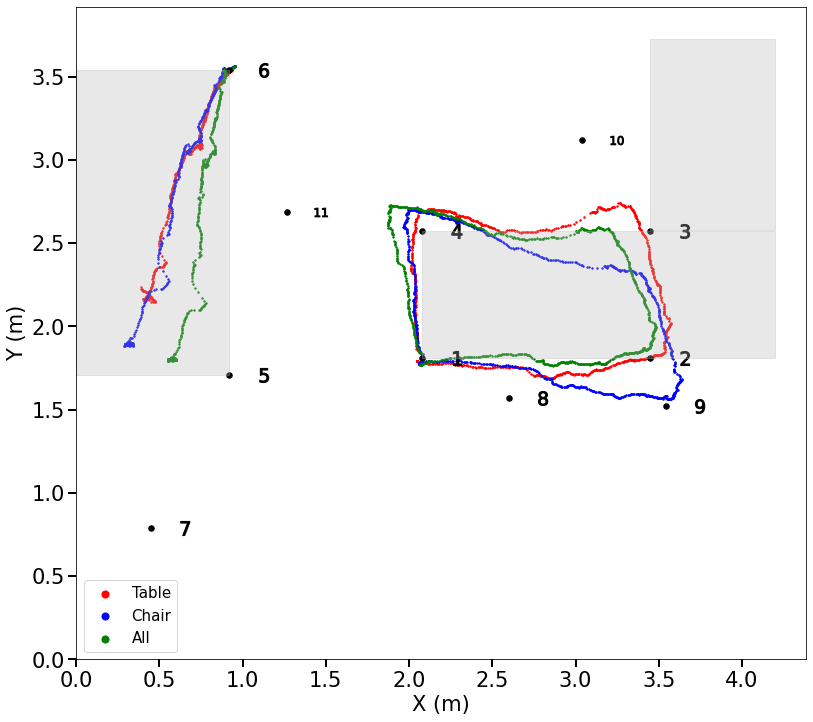

In [25]:
num_eig_vec = 3
EVENT_DOA = [active_L_table_slide_DOA, active_long_table_slide_DOA]
EVENT_LABEL = ['L Table Slide', 'Long Table slide']
B_MATRIX_NAME = ['Table','Chair','All']
COLOR_LIST = ['r','b','g']
MARKER_LIST = ["$1$","$2$","$3$","$4$","$5$","$6$","$7$","$8$","$9$","$10$","$11$"]

fig = plt.figure(figsize = [16,12])
plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(1,1,1)
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

for ii in range(len(EVENT_DOA)):
    for jj in range(len(DATA_IND)):
        DOA_points = [DOA_LIST[IND] for IND in DATA_IND[jj]]
        
        ######################## Project DOA_points onto eigenvectors, and reconstruct them here ########################
        
        # multiply DOA with U to obtain projections
        U = EIG_VEC_LIST[jj]
        proj = EVENT_DOA[ii] @ U[:,:num_eig_vec]
        
        ########################## Reconstruct DOAs from projections ##########################
        reconstructed_DOA  = (U[:,:num_eig_vec] @ (proj.T))
        room_coordinates = ROOM_COORDINATES[DATA_IND[jj],:]
        B,R_mean,D_mean,D = generate_linear_transform_matrix(DOA_points, room_coordinates, 2) 
        
        a_i = D_LIST[ii].T @ U[:,:num_eig_vec]
        
        reconstructed_a_i = (U[:,:num_eig_vec] @ (a_i.T))
        
        R_0 = R_LIST[ii]-B @ reconstructed_a_i
        r = R_0 +B @ reconstructed_DOA
        # only plot with label once
        if ii==0:
            ax.scatter(r[0,:], r[1,:], c=COLOR_LIST[jj], s=2) 
        else:
            ax.scatter(r[0,:], r[1,:], c=COLOR_LIST[jj], s=2, label=B_MATRIX_NAME[jj])    
ax.add_patch(rect_side_table), ax.add_patch(rect_main_table_1), ax.add_patch(rect_main_table_2)
ax.set_xlabel("X (m)", fontsize = 21), ax.set_ylabel("Y (m)", fontsize = 21)
ax.set_aspect('equal')
ax.set(xlim=(0,4.385), ylim=(0,3.918))
ax.scatter(ROOM_COORDINATES[:,0],ROOM_COORDINATES[:,1], c='k', s=30)
ax.tick_params(axis='y', labelsize = 21, width = 2, length = 8)
ax.tick_params(axis='x',labelsize = 21, width = 2, length = 8)

for kk in range(ROOM_COORDINATES.shape[0]):
    ax.scatter(ROOM_COORDINATES[kk,0]+0.2, ROOM_COORDINATES[kk,1], marker=MARKER_LIST[kk], s=200, c='k')
ax.legend(markerscale=5,fontsize=15)
plt.show()
fig.savefig('MappingtablesSVD.pdf', bbox_inches='tight', pad_inches=0)

### Using new mapping in figure 11

In [26]:
DOA_LIST = cp_list
ROOM_COORDINATES = ROOM_COORDINATES

# use cp 1 to calculate displacement for L table slide
R_1 = ROOM_COORDINATES[0,:2].T.reshape(-1,1)
D_1 = np.median(DOA_LIST[0], axis=0).reshape(-1,1)
# use cp 6 to calculate displacement for long table slide
R_6 = ROOM_COORDINATES[5,:2].T.reshape(-1,1)
D_6 = np.median(DOA_LIST[5], axis=0).reshape(-1,1)

R_LIST = [R_1, R_6]
D_LIST = [D_1, D_6]

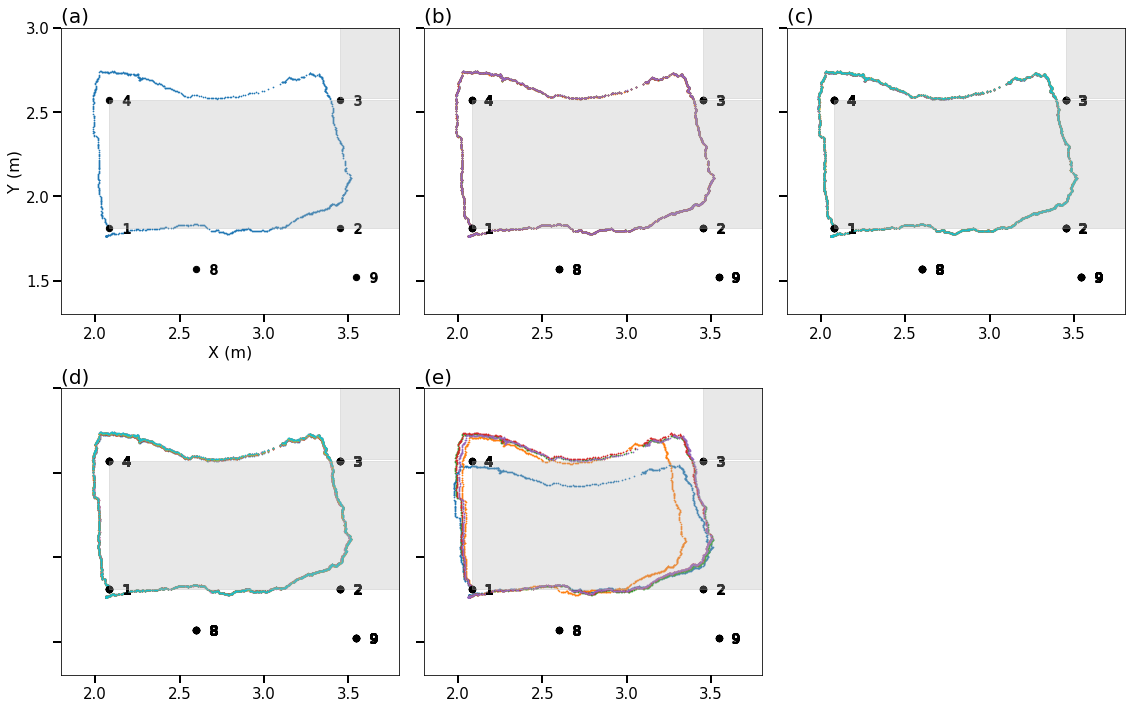

In [27]:
num_eig_vec = 2
L_TABLE_CP_IND = [0,1,2,3]
EVENT_DOA = active_L_table_slide_DOA
# DOA_LIST = cp_list[:4] # changing this to train B using all table points
DOA_LIST = cp_list[:np.shape(L_TABLE_CP_IND)[0]]
# Updating eigen vectors
_, U = get_eigen_vectors(np.vstack([cp_list[i] for i in range(0,np.shape(L_TABLE_CP_IND)[0])]))

MARKER_LIST = ["$1$","$2$","$3$","$4$","$5$","$6$","$7$","$8$","$9$","$10$","$11$"]
PLOT_LABLES = ['(a) ', '(b) ', '(c) ', '(d) ','(e) ']
TOTAL_ARRAY_NUM = 5 # N

fig = plt.figure(figsize = [16,10])
LABEL_IND = 0
for CHOOSE_ARRAY_NUM in [5,4,3,2,1]: #[5, 4, 3, 2, 1]:
    rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
    rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
    rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

    ax = fig.add_subplot(2,3,6-CHOOSE_ARRAY_NUM)
    ax.add_patch(rect_main_table_1),  ax.add_patch(rect_main_table_2)
    B_different_combinations = [] # will store all B matrices
    B_different_combinations_padded = []
#     r_test = [],     R_0_test = []

    which_arrays = list(itertools.combinations(range(TOTAL_ARRAY_NUM), CHOOSE_ARRAY_NUM))
    for i in which_arrays:
        data_indices = get_indices_from_combination(i)
        DOA_points = [cp[:,data_indices] for cp in DOA_LIST]
        
        ############################################################################################     
        proj = EVENT_DOA @ U[:,:num_eig_vec]
        reconstructed_DOA  = (U[:,:num_eig_vec] @ (proj.T))        
        
        B,R_mean,D_mean,D = generate_linear_transform_matrix(DOA_points, ROOM_COORDINATES[:np.shape(L_TABLE_CP_IND)[0],:], 2)
    
        B_padded = pad_linear_transform_matrix(B, i)   
#        B_different_combinations.append(B),       B_different_combinations_padded.append(B_padded)
    
        # use B_padded
        a_1 = D_1.T @ U[:,:num_eig_vec]
        reconstructed_D_1 = (U[:,:num_eig_vec] @ (a_1.T))           
        R_0 = R_1 - B_padded @ reconstructed_D_1
        r = R_0 + B_padded @ reconstructed_DOA
#         r_test.append(r),        R_0_test.append(R_0)
        #############################################################################################

        ax.set(xlim=(1.8,3.8), ylim=(1.3,3))
        ax.scatter(r[0,:], r[1,:], s=0.5, label=i)
        ax.set_aspect('equal')
        ax.scatter(ROOM_COORDINATES[:,0], ROOM_COORDINATES[:,1], c ='k', s=40)
        for j in range(ROOM_COORDINATES.shape[0]):
            ax.scatter(ROOM_COORDINATES[j,0]+0.1, ROOM_COORDINATES[j,1], marker=MARKER_LIST[j] , s=100, c='k')
            
    ax.set_ylabel
    ax.set_title(PLOT_LABLES[LABEL_IND], fontsize=20, loc='left')
    LABEL_IND += 1
    plt.locator_params(axis='y', nbins=6)
    
    if CHOOSE_ARRAY_NUM == 5:
        ax.set_xlabel("X (m)"),   ax.set_ylabel("Y (m)")
        
    # hiding tick labels for not 5
    if CHOOSE_ARRAY_NUM != 5:
        ax.get_yaxis().set_ticklabels([])
    # making ticks stronger
    ax.tick_params(axis='y',labelsize=15, width = 2, length = 8), ax.tick_params(axis='x',labelsize=15, width = 2, length = 8)

plt.tight_layout()
        
fig.savefig('MappingtableMissingArraysSVD.pdf', bbox_inches='tight', pad_inches=0)
# ax.legend(markerscale=10,fontsize=15)

### Using this mapping in figure 12 a.


In [28]:
num_eig_vec = 3

DOA_LIST = cp_list
ROOM_COORDINATES = ROOM_COORDINATES

L_TABLE_CP_IND = [0,1,2,3]
EIGEN_VALUES_L_TABLE, EIGEN_VECTORS_L_TABLE = get_eigen_vectors(np.vstack([cp_list[i] for i in L_TABLE_CP_IND]))
B_FULL,_,_,_ = generate_linear_transform_matrix(DOA_LIST[:4], ROOM_COORDINATES[:4,:], 2) 
_, U = get_eigen_vectors(np.vstack([cp_list[i] for i in range(0,4)]))

# use cp 1 to calculate displacement for L table slide
R_1 = ROOM_COORDINATES[0,:2].T.reshape(-1,1)
D_1 = np.median(DOA_LIST[0], axis=0).reshape(-1,1)

In [29]:
# Generate data
random.seed(10)
L = active_L_table_slide_DOA.shape[0]
# choose how many arrays are active
CHOOSE = 4
# choose dropping rate
OCCURANCE = 0.5
OCCURANCE_TIMEIND = random.sample(range(L),np.floor(L*OCCURANCE).astype('int'))
OCCURANCE_TIMEIND.sort()
mapped_r = []
mapped_p = []

# Create a random array indices for all observations, maybe 1 or more arrays are dropped
active_combo = []
inactive_combo = []
for jj in OCCURANCE_TIMEIND:
    active = random.sample([0,1,2,3,4],CHOOSE)
    inactive = list(set([0,1,2,3,4])-set(active))
    active_combo.append(active)
    inactive_combo.append(inactive)
   
# projecting and reconstructing D_1
proj_D_1 = D_1.T @ U[:,:num_eig_vec]
reconstructed_D_1 = (U[:,:num_eig_vec] @ (proj_D_1.T))

# Calculation for B
tracker = 0
for ll in range(L):
    
    ##################################################################################################
    proj_L_table_slide = active_L_table_slide_DOA[ll,:].reshape(1,-1) @ U[:,:num_eig_vec]
    reconstructed_DOA  = (U[:,:num_eig_vec] @ (proj_L_table_slide.T)) 
    
    if ll in OCCURANCE_TIMEIND:
        combo = active_combo[tracker]
        tracker += 1
        data_indices = get_indices_from_combination(combo)
        DOA_points = [cp[:,data_indices] for cp in DOA_LIST[:6]]
        
        B,R_mean,D_mean,D = generate_linear_transform_matrix(DOA_points, ROOM_COORDINATES[:,:6], 2) 
        B_padded = pad_linear_transform_matrix(B, combo)   
        
        R_0 = R_1 - B_padded @ reconstructed_D_1
        r = R_0 + B_padded @ reconstructed_DOA
        ##################################################################################################
    else: 
        R_0 = R_1 - B_FULL @ reconstructed_D_1
        r = R_0 + B_FULL @ reconstructed_DOA
    mapped_r.append(r)
    
# Calculation for PCA 
tracker = 0
for ll in range(L):
    if ll in OCCURANCE_TIMEIND:
        combo = inactive_combo[tracker]
        tracker += 1
        data_indices = get_indices_from_combination(combo)
        tmp = active_L_table_slide_DOA[ll,:].copy()
        tmp[data_indices] = 0
    else: 
        tmp = active_L_table_slide_DOA[ll,:].copy()
    p = project_to_eigen_vectors(tmp, 2, EIGEN_VALUES_L_TABLE, EIGEN_VECTORS_L_TABLE)    
    mapped_p.append(p)

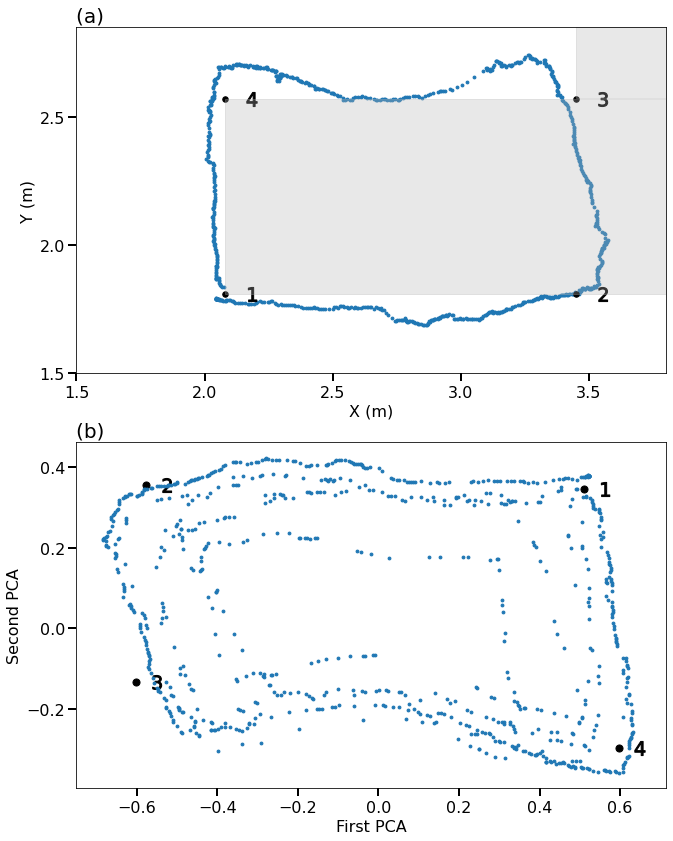

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = [12,14])
plt.rcParams['font.size'] = '18'
PLOT_LABLES = ['(a) ', '(b) ', '(c) ']

MARKER_LIST = ["$1$","$2$","$3$","$4$","$5$","$6$","$7$","$8$","$9$","$10$","$11$"]

# B matrix
r_result = np.hstack(mapped_r)
axes[0].scatter(r_result[0,:], r_result[1,:], s=8)
axes[0].scatter(ROOM_COORDINATES[:4,0], ROOM_COORDINATES[:4,1], c='k', s=30)

for kk in range(4):
    axes[0].scatter(ROOM_COORDINATES[kk,0]+0.1, ROOM_COORDINATES[kk,1], marker=MARKER_LIST[kk], s=200, c='k')
    
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.575), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')
axes[0].set(xlim=(1.5,3.8), ylim=(1.5,2.85))
axes[0].set_title(PLOT_LABLES[0], fontsize=20, loc = 'left')
axes[0].set_xlabel("X (m)"), axes[0].set_ylabel("Y (m)")
axes[0].set_aspect('equal')
axes[0].set_anchor('W')
axes[0].locator_params(axis='y', nbins=4)
axes[0].tick_params(axis='y', width = 2, length = 8), axes[0].tick_params(axis='x', width = 2, length = 8)
axes[0].add_patch(rect_main_table_1), axes[0].add_patch(rect_main_table_2)

# PCA matrix
p_result = np.vstack(mapped_p)
cp = np.hstack([np.median(DOA_LIST[L_TABLE_CP_IND], axis=0).reshape(-1,1) for L_TABLE_CP_IND in range(len(DOA_LIST))]).T
cp_projections = project_to_eigen_vectors(cp, 2,
                                          EIGEN_VALUES_L_TABLE, 
                                          EIGEN_VECTORS_L_TABLE)
axes[1].scatter(cp_projections[:4,0], cp_projections[:4,1], c='k', s=50)
for kk in range(4):
    axes[1].scatter(cp_projections[kk,0]+.05, cp_projections[kk,1], marker=MARKER_LIST[kk], s=200, c='k')

axes[1].scatter(p_result[:,0], p_result[:,1], s=8)
axes[1].set_title(PLOT_LABLES[1], fontsize=20, loc = 'left')
axes[1].set_aspect('equal')
axes[1].set_xlabel("First PCA")  
axes[1].set_ylabel("Second PCA")
axes[1].set_anchor('W')
axes[1].locator_params(axis='y', nbins=6)
axes[1].tick_params(axis='y', width = 2, length = 8)
axes[1].tick_params(axis='x', width = 2, length = 8)

plt.show()
fig.savefig('MappingtableMissingArraysRandomSVD.pdf', bbox_inches='tight', pad_inches=0)